Жданова Яна ИУ5-64Б

#НИРС

# Введение

Ссылка на датасет:
- https://www.kaggle.com/datasets/aadarshvelu/heart-failure-prediction-clinical-records/data

Сердечная недостаточность - серьезное заболевание, которое требует своевременной диагностики и эффективного лечения, а на данный момент является одной из ведущих причин смертности и госпитализации во всем мире, представляя значительную нагрузку на системы здравоохранения. Ранняя диагностика и эффективное управление заболеванием могут значительно улучшить прогнозы и качество жизни пациентов.

В последние годы машинное обучение выявило свой потенциал как мощный инструмент для анализа медицинских данных и предсказания медицинских исходов, включая сердечную недостаточность.

Целью данной исследовательской работы является разработка и оценка моделей машинного обучения для предсказания риска сердечной недостаточности на основе клинических данных пациентов.



# Импорт данных и необходимых библиотек

## Импорт библиотек

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

## Импорт данных

In [3]:
data = pd.read_csv('heart_failure_clinical_records.csv', encoding = 'ISO-8859-1')

Первые 5 строк датасета:

In [4]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


# Предварительная обработка данных


Размер датасета:

In [5]:
data.shape

(5000, 13)

Типы данных в датасете:

In [6]:
data.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

Кодирование категориальных признаков не требуется.

Проверим, есть ли в датасете пропущенные значения:

In [7]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

В данном датасете отсутствуют пропущенные значения.

# Разведочный анализ данных

Целевым признаком в данном датасете является смерть пациента в ходе клинического исследования - DEATH_EVENT. Определим уникальные значения для целевого признака:

In [8]:
data['DEATH_EVENT'].unique()

array([0, 1])

Целевой признак является бинарным и содержит только значения 0 и 1.



Построим комбинации гистограмм и диаграмм рассеивания для всего набора данных:

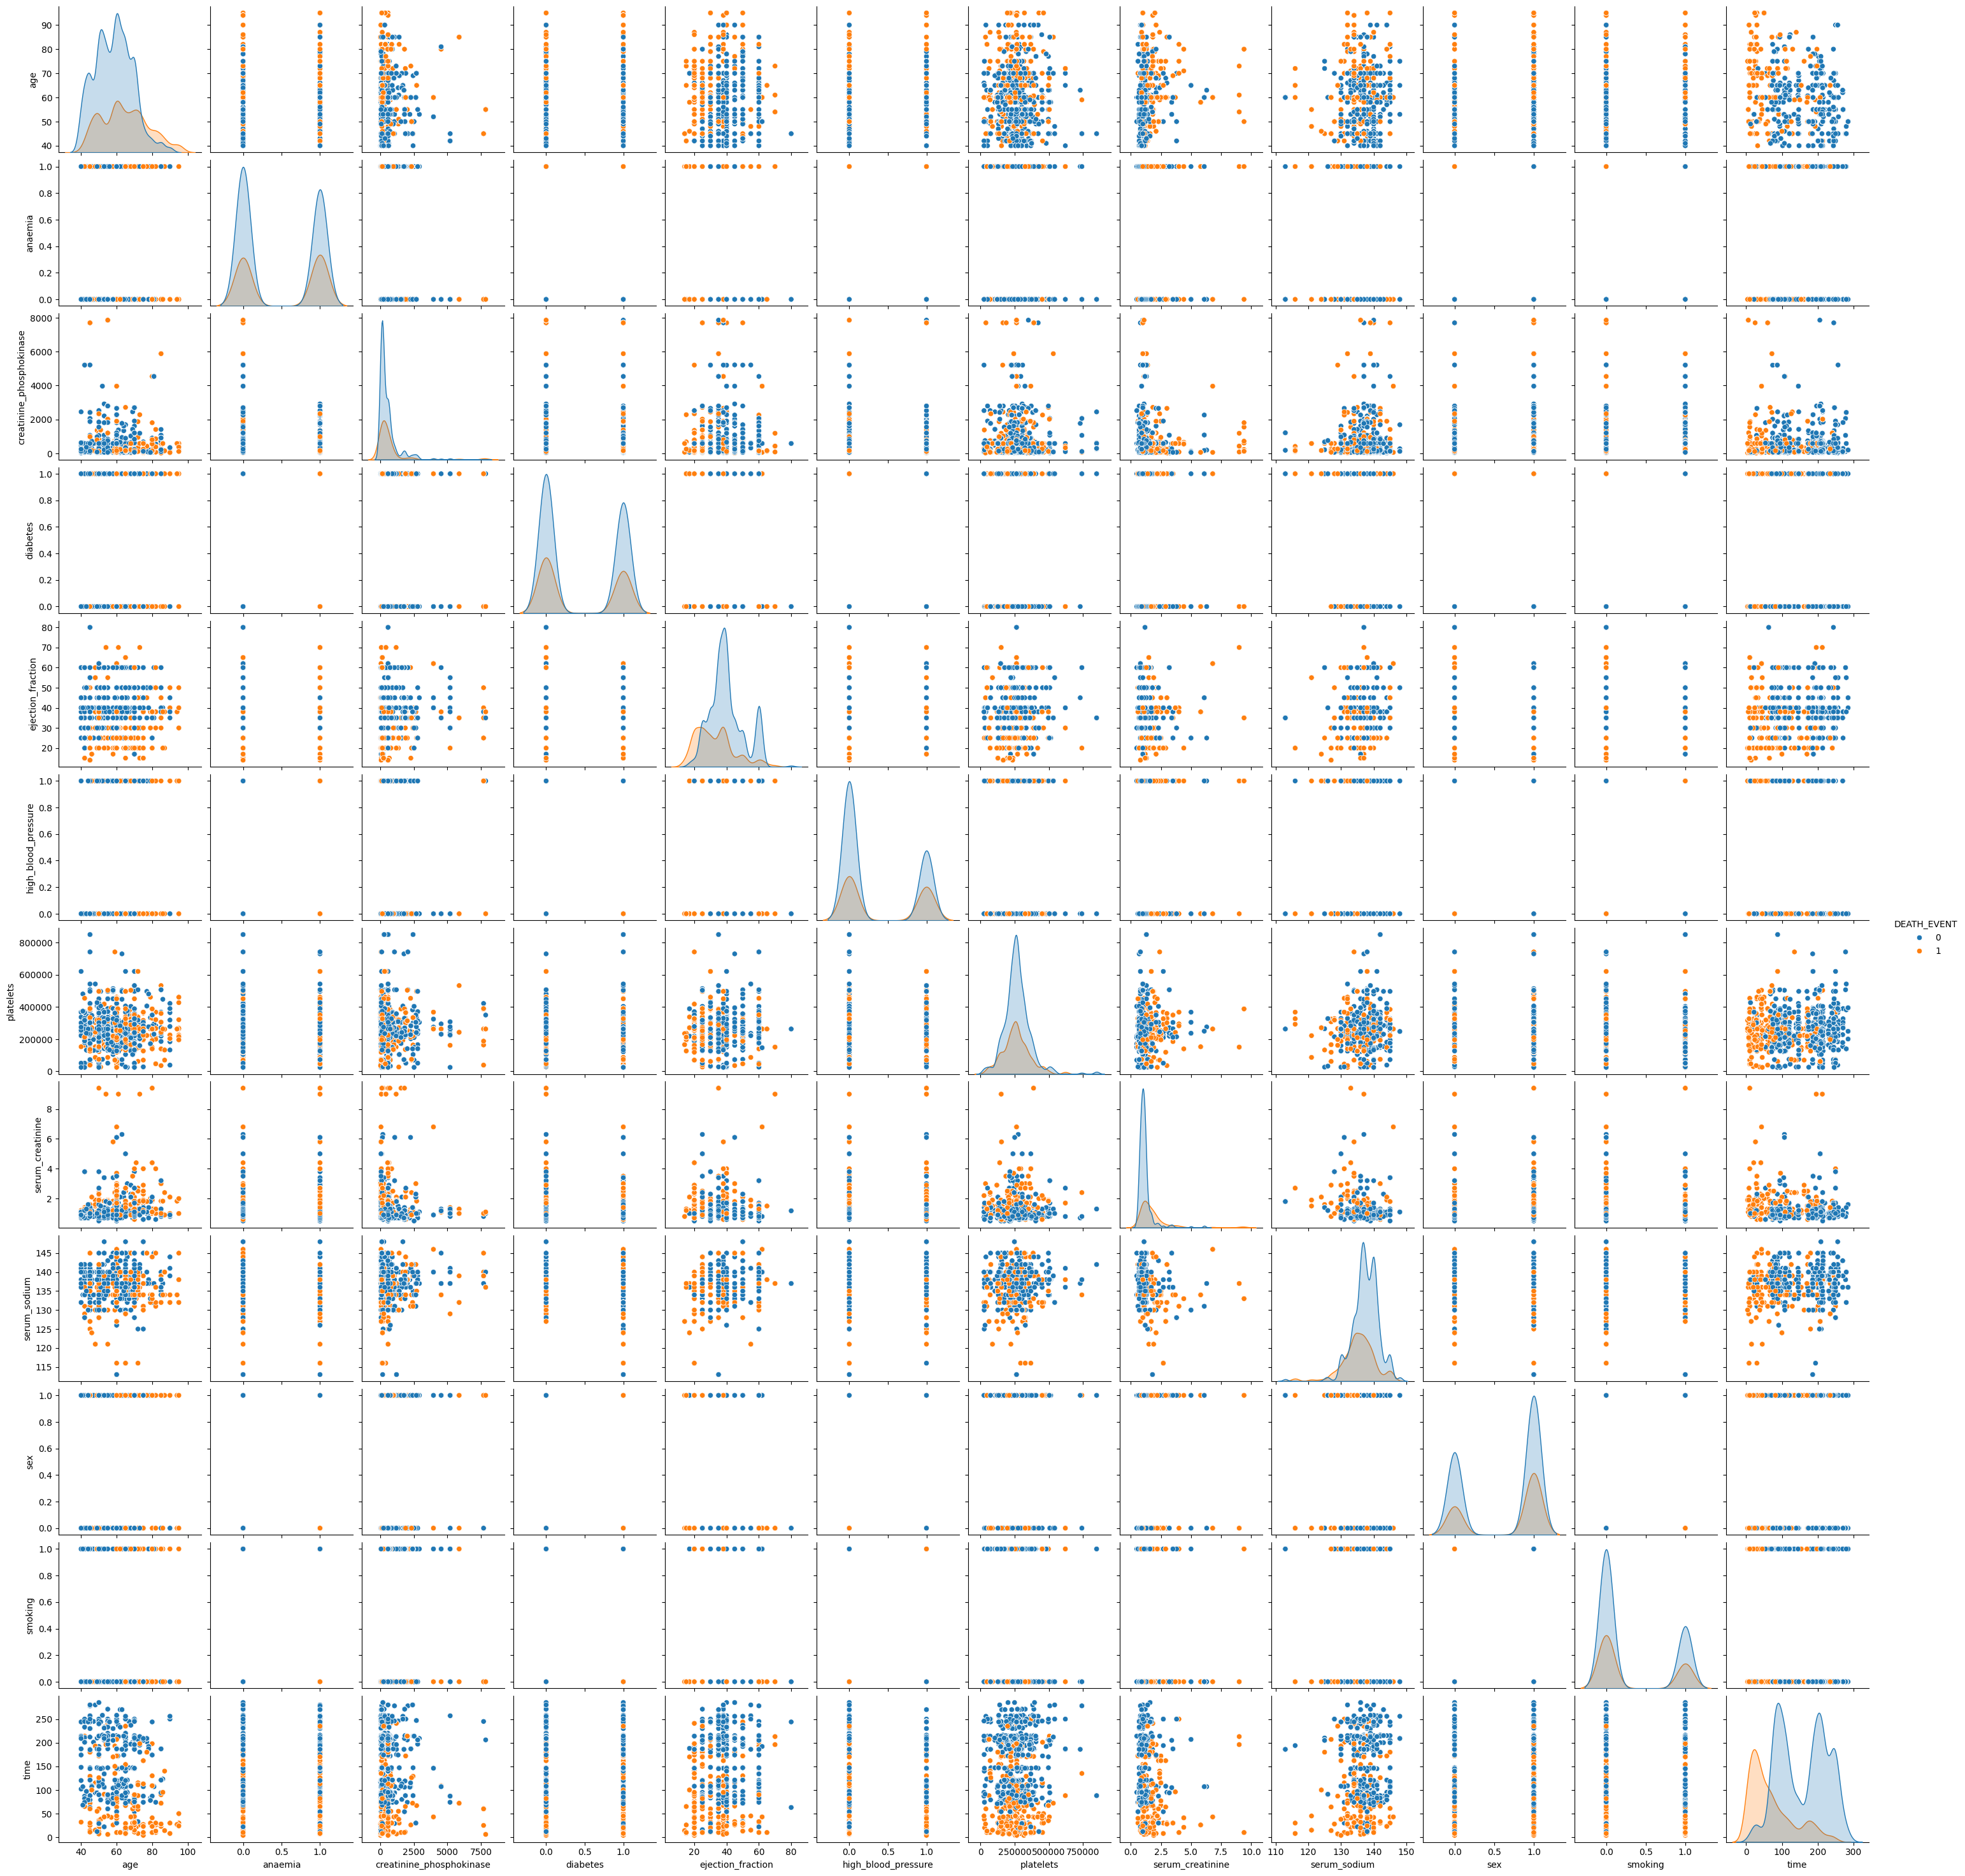

In [9]:
sns.pairplot(data, hue = 'DEATH_EVENT')

# Корреляционный анализ данных

<Axes: >

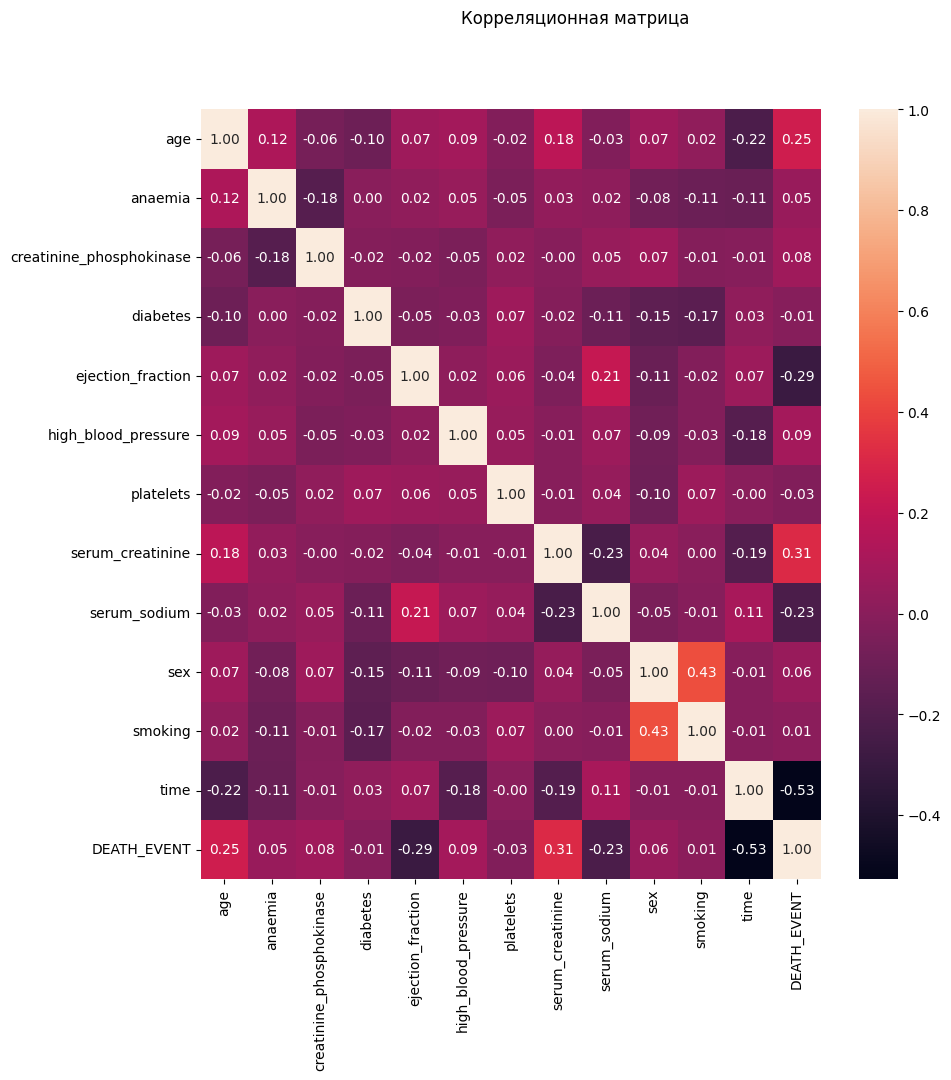

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('Корреляционная матрица')
sns.heatmap(data.corr(), ax=ax, annot=True, fmt='.2f')

**Исходя из матрицы корреляции можно сделать следующие промежуточные выводы:**
- Большинство признаков достаточно имеют достаточно слабую корреляцию
- Отсутствуют линейно зависимые признаки
- Целевой признак не имеет сильную зависимоть ни от одного другого признака
- Одна из самых сильных зависимостей наблюдается между полом пациента (sex) и тем, курит он или нет (smoking)

Не очень хорошее качество корреляционной матрицы Пирсона объясняется тем, что значительная часть признаков - бинарные значения.

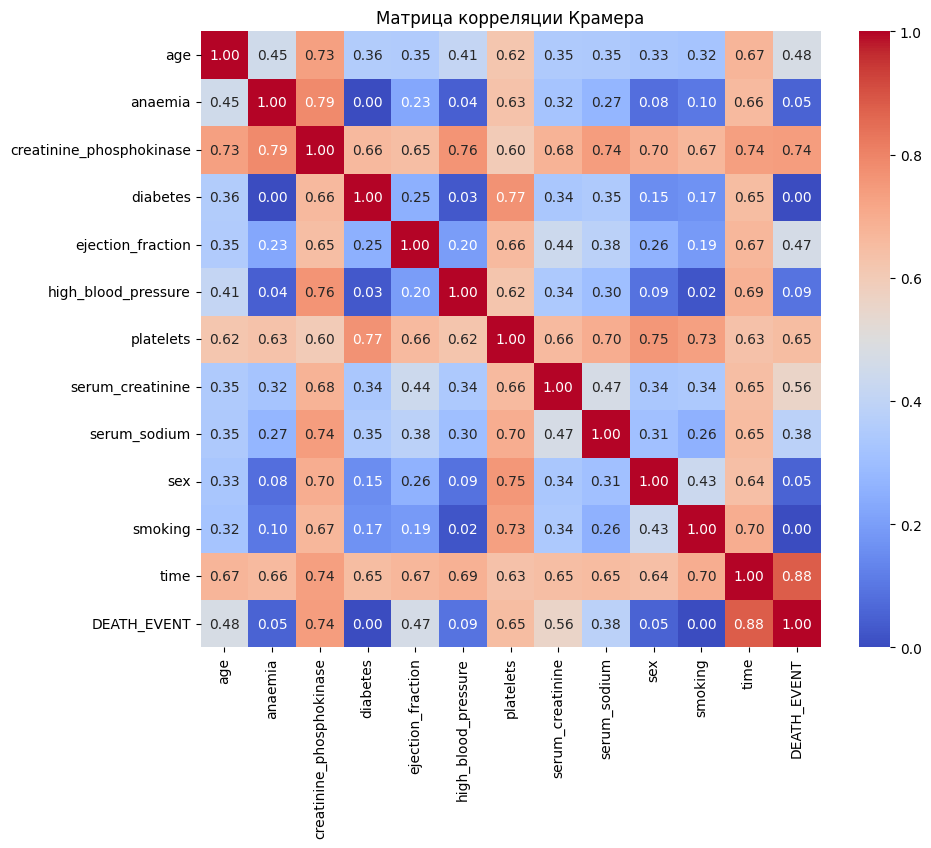

In [11]:
from scipy.stats import chi2_contingency

# Функция для расчета коэффициента корреляции Крамера
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# Функция для создания матрицы корреляции Крамера
def cramers_v_matrix(df):
    cols = df.columns
    n = len(cols)
    corr_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                corr_matrix[i, j] = 1
            else:
                cell = cramers_v(pd.crosstab(df[cols[i]], df[cols[j]]))
                corr_matrix[i, j] = cell
                corr_matrix[j, i] = cell
    return pd.DataFrame(corr_matrix, index=cols, columns=cols)

# Создание матрицы корреляции
data_k = data
corr_matrix = cramers_v_matrix(data_k)

# Визуализация матрицы корреляции
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Матрица корреляции Крамера')
plt.show()

# Выбор метрик для последующей оценки качества моделей

In [12]:
# !pip install nbconvert

**Для оценки качества моделей, решающих задачу классификации, выберем следующие метрики:**
1. ***Accuracy*** - метрика вычисляет процент (долю в диапазоне от 0 до 1) правильно определенных классов, то есть долю верно предсказанных классификатором положительных и отрицательных объектов.

2. ***F-мера*** - Для того, чтобы объединить precision и recall в единую метрику используется Fβ -мера, которая вычисляется как среднее гармоническое от precision и recall. На практике чаще всего используют вариант F1-меры (которую часто называют F-мерой) при β=1. Поскольку метрика учитывает баланс между точностью и полнотой, это делает её особенно полезной в ситуациях, когда важно учитывать как ложноположительные, так и ложноотрицательные результаты.

3. ***ROC AUC*** - используется для оценки качества бинарной классификации. Основана на вычислении характеристик True Positive Rate и False Positive Rate. Идеальная ROC-кривая проходит через точки (0,0)-(0,1)-(1,1), то есть через верхний левый угол графика.
Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации. В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.

# Выбор наиболее подходящих моделей для решения задачи классификации

**Для решения задачи классификации будем использовать следующие модели:**
1. Логистическая регрессия
2. Дерево решений
3. Случайный лес
4. Градиентный бустинг
5. Адаптивный бустинг



# Формирование обучающей и тестовой выборок

In [13]:
# Признаки без целевой переменной
x = data.drop('DEATH_EVENT', axis=1)
x.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50


In [14]:
# Целевая переменная
y = data['DEATH_EVENT']
y.head()

0    0
1    0
2    0
3    0
4    1
Name: DEATH_EVENT, dtype: int64

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
#20% данных будут отложены для тестирования, а 80% будут использованы для обучения модели

In [16]:
# Размер обучающей выборки
x_train.shape, y_train.shape

((4000, 12), (4000,))

In [17]:
# Размер тестовой выборки
x_test.shape, y_test.shape

((1000, 12), (1000,))

# Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров

In [36]:
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier()]

for model in models:
  model.fit(x_train, y_train)
  print(f"{type(model).__name__}:")
  print('\t',f"accuracy = {accuracy_score(y_test,model.predict(x_test))}")
  print('\t',f"f1 = {f1_score(y_test,model.predict(x_test))}")
  print('\t',f"roc_auc = {roc_auc_score(y_test,model.predict(x_test))}", '\n')

LogisticRegression:
	 accuracy = 0.826
	 f1 = 0.7070707070707071
	 roc_auc = 0.782570878673477 

DecisionTreeClassifier:
	 accuracy = 0.991
	 f1 = 0.9856459330143541
	 roc_auc = 0.9874620623288178 

RandomForestClassifier:
	 accuracy = 0.991
	 f1 = 0.985553772070626
	 roc_auc = 0.985759493670886 

GradientBoostingClassifier:
	 accuracy = 0.964
	 f1 = 0.9411764705882353
	 roc_auc = 0.9498482493152712 

AdaBoostClassifier:
	 accuracy = 0.921
	 f1 = 0.8715447154471544
	 roc_auc = 0.9013898141979422 



# Подбор гиперпараметров для выбранных моделей

In [29]:
optimal_models = []

params = [
    {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
    {'max_depth': [5, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    {'n_estimators': [100, 300, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 20, 30]},
    {'n_estimators': [100, 300, 500], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
]

for model, param in zip(models, params):
  clf_gs = GridSearchCV(model, param, cv=5, scoring='f1_macro')
  clf_gs.fit(x_train, y_train)
  optimal_model = clf_gs.best_estimator_
  optimal_models.append(optimal_model)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceba

Выбранные оптимальные значения гиперпараметров:

In [30]:
optimal_models

[LogisticRegression(C=0.001),
 DecisionTreeClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5),
 RandomForestClassifier(max_depth=30),
 GradientBoostingClassifier(max_depth=5, n_estimators=500),
 AdaBoostClassifier(learning_rate=1, n_estimators=200)]

# Построение моделей для найденных оптимальных значений гиперпараметров и их оценка

In [31]:
for model in optimal_models:
  model.fit(x_train, y_train)
  print(f"{type(model).__name__}:")
  print('\t',f"accuracy = {accuracy_score(y_test,model.predict(x_test))}")
  print('\t',f"f1 = {f1_score(y_test,model.predict(x_test))}")
  print('\t',f"roc_auc = {roc_auc_score(y_test,model.predict(x_test))}", '\n')

LogisticRegression:
	 accuracy = 0.832
	 f1 = 0.7142857142857144
	 roc_auc = 0.7869568435857577 

DecisionTreeClassifier:
	 accuracy = 0.987
	 f1 = 0.9791332263242376
	 roc_auc = 0.9811329484047673 

RandomForestClassifier:
	 accuracy = 0.991
	 f1 = 0.985553772070626
	 roc_auc = 0.985759493670886 

GradientBoostingClassifier:
	 accuracy = 0.994
	 f1 = 0.9904458598726115
	 roc_auc = 0.9913576134428899 

AdaBoostClassifier:
	 accuracy = 0.962
	 f1 = 0.9372937293729372
	 roc_auc = 0.9449811236953142 



# Формирование выводов о качестве построенных моделей на основе выбранных метрик.

## Сравнение качества полученных моделей с качеством baseline-моделей

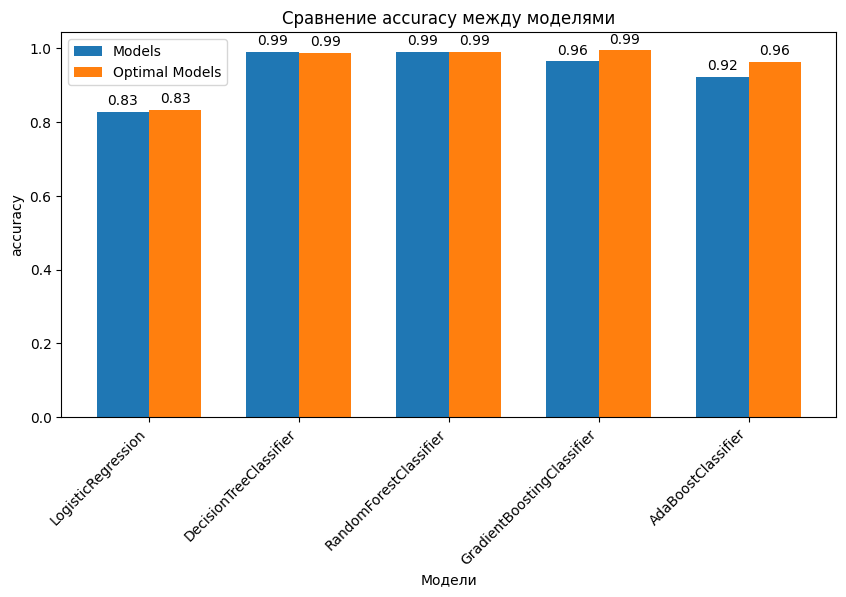

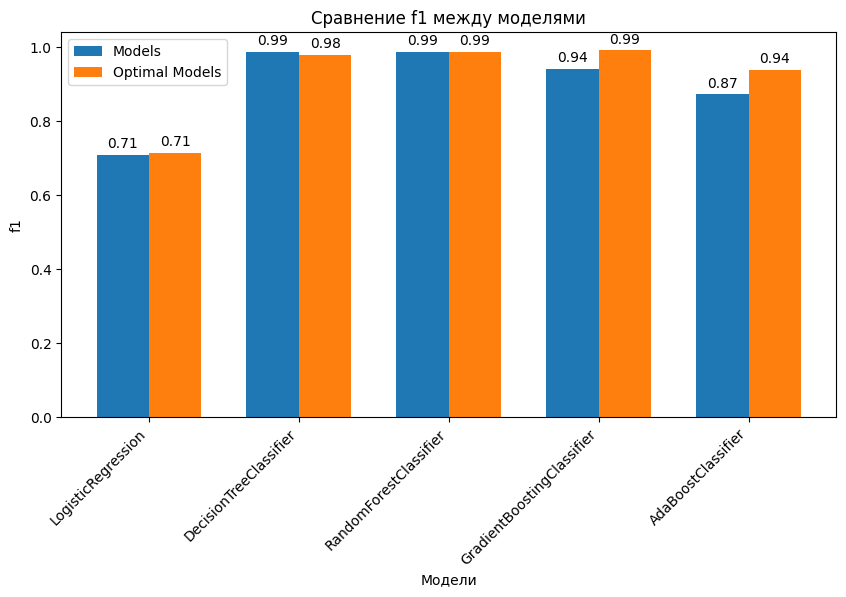

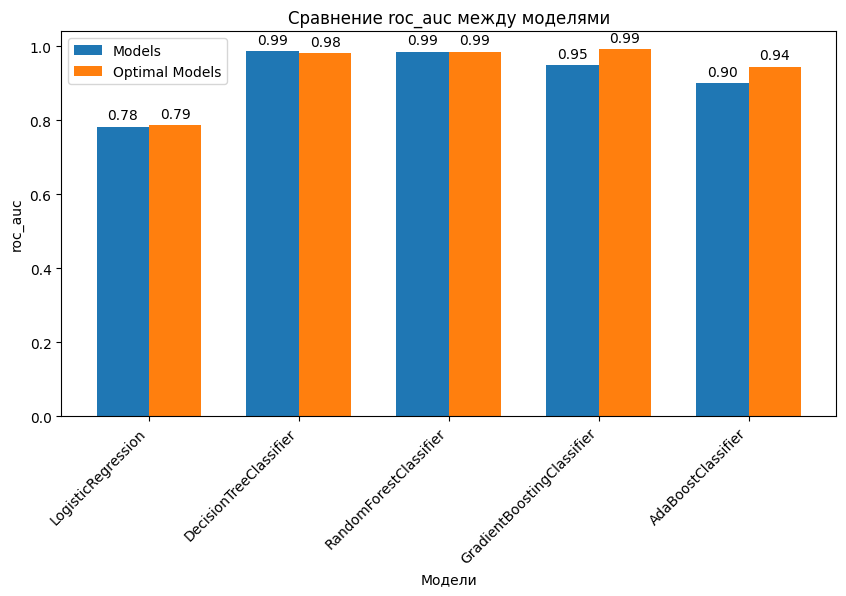

In [48]:
# Сначала вычисляем метрики для каждой модели
metrics = {'accuracy': accuracy_score, 'f1': f1_score, 'roc_auc': roc_auc_score}
results = {'models': {}, 'optimal_models': {}}

for group_name, group in zip(['models', 'optimal_models'], [models, optimal_models]):
    for model in group:
        model_name = type(model).__name__
        y_pred = model.predict(x_test)
        results[group_name][model_name] = {metric: metrics[metric](y_test, y_pred) for metric in metrics}

# Теперь создаем графики
num_metrics = len(metrics)
width = 0.35  # ширина столбцов

for i, metric in enumerate(metrics, 1):
    fig, ax = plt.subplots(figsize = (10, 5))
    model_names = list(results['models'].keys())
    model_scores = [results['models'][name][metric] for name in model_names]
    optimal_scores = [results['optimal_models'][name][metric] for name in model_names]

    # Расположение столбцов на оси X
    ind = np.arange(len(model_names))

    # Столбцы для первого набора моделей
    bars1 = ax.bar(ind - width/2, model_scores, width, label='Models')

    # Столбцы для второго набора моделей
    bars2 = ax.bar(ind + width/2, optimal_scores, width, label='Optimal Models')

    # Названия и метки
    ax.set_xlabel('Модели')
    ax.set_ylabel(metric)
    ax.set_title(f'Сравнение {metric} между моделями')
    ax.set_xticks(ind)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend()

    # Выводим значения над столбцами
    def autolabel(bars):
        """Прикрепляем текстовую метку над каждым столбцом, показывающую его высоту."""
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # смещение надписи
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(bars1)
    autolabel(bars2)

    plt.show()

# Выводы

**По результатам проведенного исследования можно сделать следующие выводы:**

1. Модели изначально продемонстрировали достаточно хорошие результаты, но после выполнения настройки гиперпараметров, показатели метрик всё же немного возросли, что свидетельствует о том, что после установки оптимальных гиперпараметров качество моделей улучшилось.

2. Самые лучшие результаты что до, что после устновки гипрпараметров, показала модель Random Forest. Показатели метрик для этой модели следующие:  
  - Accuracy = 0.991
  - F-мера = 0.985553772070626
  - Roc Auc = 0.985759493670886

3. Напротив, самые худшие результаты среди моделей показала Logistic Regression, её предсказания содержали в себе больше всего ошибок. Метрики для оценки качества для этой модели равны:
  - Accuracy = 0.832
  - F-мера = 0.7142857142857144
  - Roc Auc = 0.7869568435857577

4. Остальные модели, такие как Decision Tree, Gradient Boosting и Ada Boost, как я уже отметила ранее, тоже показали весьма достойный результат, но качество Random Forest всё же немного, но выше.

**Заключение:**

На основе результатов анализа, для задачи классификации на выбранных данных рекомендовано использовать модель случайного леса (Random Forest) после тщательной настройки гиперпараметров. Эта модель продемонстрировала наилучшие результаты по сравнению с другими рассматриваемыми моделями и может обеспечить точные и надежные предсказания.